In [1]:
%matplotlib nbagg
import matplotlib.pyplot as plt

import numpy as np
import os
import glob
import pandas as pd
import ipywidgets as wg
import re

from matplotlib.ticker import MultipleLocator
import matplotlib.lines as mlines

import warnings
warnings.filterwarnings(action="ignore", message="findfont")

## User-defined functions
from Bibliography import Bibliography
from GraphScan import GraphScan
from make_bibliography_df import make_bibliography_df
from PieOuterLabels import PieOuterLabels, func


In [2]:
## Functions for filtering data frames
def cont_keyword(df, keyword, column="Carbon type", case=True):
    return df[df[column].astype(str).str.contains(keyword, case)]

def cont_multi_keywords(df, list_of_keywords, column="Carbon type", case=True):
    return df[df[column].astype(str).str.contains("|".join(list_of_keywords), case)]

def excludes_keywords(df, list_of_keywords, column="Carbon type", case=False):
    return df[~df[column].astype(str).str.contains("|".join(list_of_keywords), case)]

In [3]:
## Plot set ups
from UCL_colors import UCL_colors
c = UCL_colors()

plt.rcParams.update({"xtick.direction": "in"})
plt.rcParams.update({"ytick.direction": "in"})
plt.rcParams.update({"xtick.top": True})
plt.rcParams.update({"ytick.right": True})

plt.rcParams.update({"font.size": 12})

pie_width = 0.3
pie_radius = 1

# Data import notes: 
* wang 2019 cotton hierarchical quotes separate BJH and BET surface area, with BET > BJH
- Note Wang 2020 Graphene nanosheets - two different composites tested with different rate change regimes!
- Wang 2017 freestanding sandwich reports formation period 12 hours before cycling!

#### Further comparators?
* Different numbers of hosts tested per paper
* Control electrodes (without host/ with only CB)

# Widgets for data import
## Article details in `Bibliography()`

In [ ]:
bib = Bibliography()
bib.tab

## Graph scanning (interpolation) in `GraphScan()`

In [ ]:
gs = GraphScan()
gs.tab

## Collate article details and numerical info in `make_bibliography_df`

In [4]:
df = make_bibliography_df()

df.insert(len(df.columns), 'concat_label', 
          [" ".join((name for name in list(df.loc[idx][["First author", "Year", "Optional label"]])))
                               for idx in range(len(df))])
df = df.set_index(np.arange(len(df)))

bibliography_list = np.unique([" ".join((name for name in list(df.loc[idx][["First author", "Year", "Optional label"]])))
                               for idx in range(len(df))])

In [5]:
## Fixing data entries that may include "+" in string to ensure mixtures are correctly identified by text search:
df["Carbon type adj"] = df["Carbon type"].str.replace("+", "mix", regex=True)

In [6]:
df["Carbon type adj"] = df["Carbon type"].str.replace("RGO", "_R_G_O", regex=True)
df["Carbon type adj"] = df["Carbon type"].str.replace("rGO", "_R_G_O", regex=True)
df["Carbon type adj"] = df["Carbon type"].str.replace("reduced graphene oxide", "_R_G_O", regex=True)
df["Carbon type adj"] = df["Carbon type"].str.replace("Reduced graphene oxide", "_R_G_O", regex=True)

In [7]:
available_data = df.iloc[[idx for idx, values in enumerate(df["Scanned data"]) if len(values)>0]]
available_data = available_data.set_index(np.arange(len(available_data)))

In [8]:
print("Number of articles scanned: "+str(len(bibliography_list)))
print("Number of individual sample types with data available: "+str(len(available_data)))
print("Number of electrochemical cycling datasets available: "+str(np.sum([len(name) for name in available_data["Scanned data"]])))

Number of articles scanned: 93
Number of individual sample types with data available: 224
Number of electrochemical cycling datasets available: 345


# Types of carbon host matrix

Define different carbon host types, and the key words to search for and/ or exclude from the user-defined labels in the `available_data` dataframe

In [9]:
carbon_types = {"Graphene": {"include": ["graphene"],
                             "exclude": ["composite", "reduced", "oxide", "mix", "_R_G_O", "GO", "wrapped"]},
                "Graphene oxide": {"include": ["graphene oxide", "GO"],
                                   "exclude": ["Reduced", "reduced", "and", "mix", "_R_G_O", "wrapped"]},
                "Reduced graphene oxide": {"include": ["_R_G_O"],
                                           "exclude": ["and", "mix", "wrapped", "graphene oxide", "GO"]},
                "Templated carbon": {"include": ["hierarchical", "template", "CMK", "mesoporous"],
                                     "exclude": ["graphene", "mix", "wrapped"]},
                "Carbon nanotubes": {"include": ["nanotube", "CNT", "MWNT"],
                                     "exclude": ["and", "graphene oxide", "mix", "wrapped"]}
                }

Identify the rows of `available_data` that include the keywords used to define each category, excluding keywords indicative of overalapping with other categories:

In [10]:
carbon_data = dict([(keys, 
                     cont_multi_keywords(df=excludes_keywords(df=available_data,
                                                              list_of_keywords=values["exclude"],
                                                              column="Carbon type adj",
                                                              case=True),
                                        list_of_keywords=values["include"],
                                        column="Carbon type",
                                        case=False)) for keys, values in carbon_types.items()])

Identify the rows of `available_data` that include the keywords used to define each category, **including** keywords which may result in overlaps between different categories:

In [13]:
carbon_data_inclusive = dict([(keys, 
                               cont_multi_keywords(df=available_data,
                                                   list_of_keywords=values["include"],
                                                   column="Carbon type adj",
                                                   case=False)) for keys, values in carbon_types.items()])

Find the rows of `carbon_data_inclusive` that do not appear in `carbon_data`: the rows identified in this step correspond to mixtures of carbon types, while filtering out rows that correspond to a single carbon type:

In [15]:
carbon_data_overlaps = {}

for nk1, keys_1 in enumerate(carbon_data_inclusive.keys()):
    for nk2, keys_2 in enumerate(carbon_data_inclusive.keys()):
        if nk2 < nk1:
            overlap_AB = set(carbon_data_inclusive[keys_1].index) & set(carbon_data_inclusive[keys_2].index)            
            carbon_data_overlaps.update([("+".join((keys_1, keys_2)), len(overlap_AB))])

`carbon_data` contains data for **single** carbon types only.

`carbon_data_overlaps` contains data for **mixed** carbon types only

These two dictionaries are combined so that the single and mixed hosts are in the same dictionary, but without duplicates:

In [16]:
carbon_types_combined = {**dict([(keys, len(values)) for keys, values in carbon_data.items()]),
                        **carbon_data_overlaps}

In [17]:
import matplotlib.patches as mpatch 

In [68]:
carbon_types_combined

{'Graphene': 23,
 'Graphene oxide': 27,
 'Reduced graphene oxide': 0,
 'Templated carbon': 76,
 'Carbon nanotubes': 30,
 'Graphene oxide+Graphene': 28,
 'Reduced graphene oxide+Graphene': 0,
 'Reduced graphene oxide+Graphene oxide': 0,
 'Templated carbon+Graphene': 6,
 'Templated carbon+Graphene oxide': 6,
 'Templated carbon+Reduced graphene oxide': 4,
 'Carbon nanotubes+Graphene': 6,
 'Carbon nanotubes+Graphene oxide': 11,
 'Carbon nanotubes+Reduced graphene oxide': 7,
 'Carbon nanotubes+Templated carbon': 3}

In [30]:
carbon_types_radii_key_adj = {"Graphene": "Gr",
                              "Graphene oxide": "GO",
                              "Reduced graphene oxide": "RGO",
                              "Templated carbon": "MC",
                              "Carbon nanotubes": "CNTs",
                              "Graphene oxide+Graphene": "Gr+\nGO",
                              "Reduced graphene oxide+Graphene": "Gr+\nRGO",
                              "Reduced graphene oxide+Graphene oxide": "RGO+\nGO",
                              'Templated carbon+Graphene': "Gr+\nMC",
                              'Templated carbon+Graphene oxide': "GO+\nMC",
                              'Templated carbon+Reduced graphene oxide': "RGO+\nMC",
                              'Carbon nanotubes+Graphene': "Gr+\nCNTs",
                              'Carbon nanotubes+Graphene oxide': "GO+\nCNTs",
                              'Carbon nanotubes+Reduced graphene oxide': "RGO+\nCNTs",
                              'Carbon nanotubes+Templated carbon': 'MC+\nCNTs'
                             }

In [31]:
carbon_types_radii = dict([(carbon_types_radii_key_adj[keys], np.sqrt(values/np.pi)) for keys, values in carbon_types_combined.items()])

In [32]:
def get_med_xy(name1, name2):
    pos1 = circle_dict[name1]._center
    pos2 = circle_dict[name2]._center
    return np.nanmedian([pos1[0], pos2[0]]), np.nanmedian([pos1[1], pos2[1]])

<IPython.core.display.Javascript object>


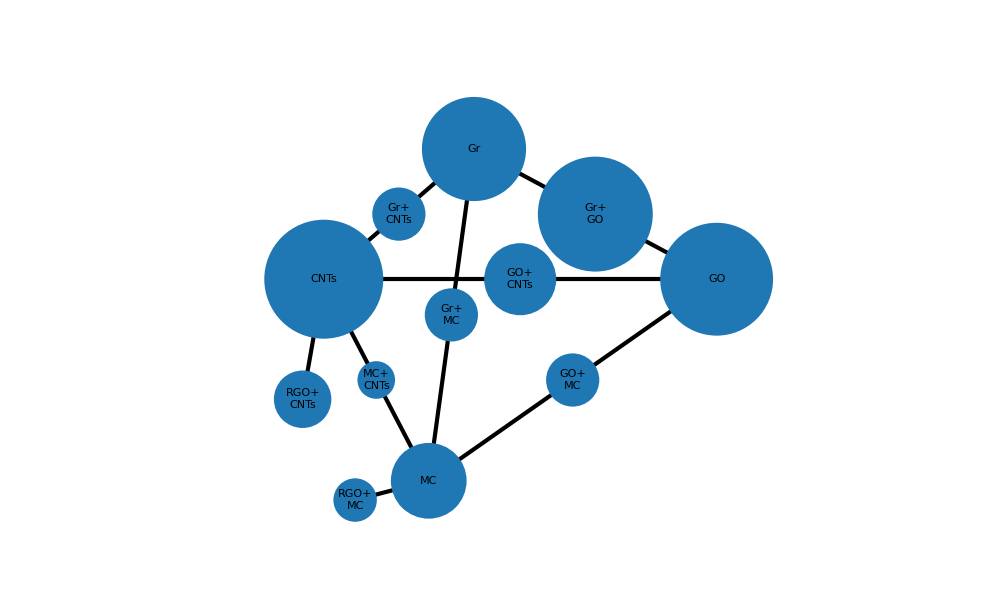

RGO 0.0
Gr+
RGO 0.0
RGO+
GO 0.0


(-30.0, 40.0, -30.0, 30.0)

In [122]:
f, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim([-30, 40])
ax.set_ylim([-30, 30])
ax.set_aspect("equal")
Rr = 10
rad_scale = 2.5

# circle_dict = {"Gr": mpatch.Circle((Rr*np.sin(0), Rr*np.cos(0)), radius=carbon_types_radii["Gr"]),
#                "GO": mpatch.Circle(((Rr*np.sin(2*np.pi/5), Rr*np.cos(2*np.pi/5))), radius=carbon_types_radii["GO"]),
#               "RGO": mpatch.Circle((Rr*np.sin(4*np.pi/5), Rr*np.cos(4*np.pi/5)), radius=carbon_types_radii["RGO"]),
#                "MC": mpatch.Circle((Rr*np.sin(6*np.pi/5), Rr*np.cos(6*np.pi/5)), radius=carbon_types_radii["MC"]),
#                "CNTs": mpatch.Circle((Rr*np.sin(8*np.pi/5), Rr*np.cos(8*np.pi/5)), radius=carbon_types_radii["CNTs"]),}

circle_dict = {"Gr": mpatch.Circle((Rr*np.sin(0), Rr*np.cos(0)+10), radius=rad_scale*carbon_types_radii["Gr"]),
               "GO": mpatch.Circle(((Rr*np.sin(2*np.pi/5)+22, Rr*np.cos(2*np.pi/5))), radius=rad_scale*carbon_types_radii["GO"]),
              "RGO": mpatch.Circle((-25, Rr*np.cos(4*np.pi/5)-20), radius=rad_scale*carbon_types_radii["RGO"]),
               "MC": mpatch.Circle((Rr*np.sin(6*np.pi/5), Rr*np.cos(6*np.pi/5)-15), radius=carbon_types_radii["MC"]),
               "CNTs": mpatch.Circle((Rr*np.sin(8*np.pi/5)-10, Rr*np.cos(8*np.pi/5)), radius=rad_scale*carbon_types_radii["CNTs"]),}

## Graphene combinations
circle_dict.update([("Gr+\nGO", mpatch.Circle((get_med_xy("Gr", "GO")[0], get_med_xy("Gr", "GO")[1]), 
                                              rad_scale*carbon_types_radii['Gr+\nGO']))])
circle_dict.update([("Gr+\nRGO", mpatch.Circle((get_med_xy("Gr", "RGO")[0], get_med_xy("Gr", "RGO")[1]), 
                                               rad_scale*carbon_types_radii['Gr+\nRGO']))])
circle_dict.update([("Gr+\nMC",  mpatch.Circle((get_med_xy("Gr", "MC")[0], get_med_xy("Gr", "MC")[1]), 
                                               rad_scale*carbon_types_radii['Gr+\nMC']))])
circle_dict.update([("Gr+\nCNTs", mpatch.Circle((get_med_xy("Gr", "CNTs")[0], get_med_xy("Gr", "CNTs")[1]), 
                                                rad_scale*carbon_types_radii['Gr+\nCNTs']))])

## GO combinations
circle_dict.update([("GO+\nCNTs", mpatch.Circle((get_med_xy("CNTs", "GO")[0], get_med_xy("CNTs", "GO")[1]), 
                                                rad_scale*carbon_types_radii['GO+\nCNTs']))])
circle_dict.update([("GO+\nMC", mpatch.Circle((get_med_xy("MC", "GO")[0], get_med_xy("MC", "GO")[1]),
                                              rad_scale*carbon_types_radii['GO+\nMC']))])

# ## RGO combinations
circle_dict.update([("RGO+\nMC", mpatch.Circle((get_med_xy("RGO", "MC")[0], get_med_xy("RGO", "MC")[1]),
                                               rad_scale*carbon_types_radii['RGO+\nMC']))])
circle_dict.update([("RGO+\nCNTs", mpatch.Circle((get_med_xy("RGO", "CNTs")[0], get_med_xy("RGO", "CNTs")[1]), 
                                                 rad_scale*carbon_types_radii['RGO+\nCNTs']))])

# ## MC combinations
circle_dict.update([("MC+\nCNTs", mpatch.Circle((get_med_xy("MC", "CNTs")[0], get_med_xy("MC", "CNTs")[1]), 
                                                rad_scale*carbon_types_radii['MC+\nCNTs']))])

import matplotlib.patches as patches

path_dict = {}
for nkey1, (key1, value) in enumerate(carbon_types_radii.items()):
    if value == 0:
        print(key1, value)
    if value > 0:
        for nkey2 in range(nkey1):
            key2 = [*carbon_types_radii.keys()][nkey2]
            if carbon_types_radii[key2] > 0:
                if all(["+" in key for key in [key1, key2]])==False:
                    if any(["+" in key for key in [key1, key2]]):
                        if(len(set(key1.split("+\n")) & set(key2.split("+\n")))>0):
                            path_dict.update([("_".join((key1, key2)), 
                                               patches.PathPatch(mpatch.Path([circle_dict[key1]._center,
                                                                              circle_dict[key2]._center],
                                                          [mpatch.Path.MOVETO, mpatch.Path.LINETO]
                                                        ), lw=3))])
                                                      
[ax.add_patch(values) for values in path_dict.values()]
[ax.add_patch(values) for values in circle_dict.values()]

for keys, values in circle_dict.items():
    if carbon_types_radii[keys] > 0:
        ax.annotate(keys, values._center, va="center", ha="center", size=8)
        
#get current axes
ax = plt.gca()

#hide axes and borders
plt.axis('off')


The order of the carbon types is set manually, so that overlapping categories are adjacent to each other. The `carbon_types_combined` dictionary is re-definied/ re-ordered according to the desired order. 

The colours to use for each carbon type are also set manually.

carbon_types_custom_order = ["Graphene", "Graphene oxide+\nGraphene", "Graphene oxide",
                             'Reduced graphene oxide+\nGraphene oxide', "Reduced graphene oxide", "Reduced graphene oxide+\nGraphene",
                            "Templated carbon", "Templated carbon+\nOther", "Carbon nanotubes",
                             "Carbon nanotubes+\nOther"]
carbon_types_combined = dict([(key, carbon_types_combined[key]) for key in carbon_types_custom_order])

carbon_types_colors = {"Graphene": [*c.saturation(60, ["Light Red"]).values()],
                       "Graphene oxide+\nGraphene": [*c.saturation(40, ["Mid Purple"]).values()],
                       "Graphene oxide": [*c.saturation(60, ["Mid Blue"]).values()],
                             'Reduced graphene oxide+\nGraphene oxide': [*c.saturation(60, ["Mid Green"]).values()],
                       "Reduced graphene oxide": [*c.saturation(60, ["Yellow"]).values()],
                       "Reduced graphene oxide+\nGraphene": [*c.saturation(60, ["Orange"]).values()],
                            "Templated carbon": [*c.saturation(100, ["Grey"]).values()],
                       "Templated carbon+\nOther": [*c.saturation(60, ["Stone"]).values()],
                       "Carbon nanotubes": [*c.saturation(60, ["Light Blue"]).values()],
                       "Carbon nanotubes+\nOther": [*c.saturation(60, ["Light Green"]).values()]}
                                                          

f, ax = plt.subplots()

ax.pie([*carbon_types_combined.values()], radius=1, wedgeprops=dict(width=0.3, edgecolor="k"))
ax.pie([20+38, 20+14+26+15+68+25+16+23], radius=1.2, wedgeprops=dict(width=0.2, edgecolor="none"), colors=[None, "none"])
ax.pie([20, 38+20+14, 26+15+68+25+16+23], radius=1.4, wedgeprops=dict(width=0.2, edgecolor="none"), colors=["none", None, "none"])
ax.pie([20+38+20, 14+26+15, 68+25+16+24], radius=1.6, wedgeprops=dict(width=0.2, edgecolor="none"), colors=["none", None, "none"])
ax.pie([20+38+20+14+26+15, 68+25, 16+23], radius=1.8, wedgeprops=dict(width=0.2, edgecolor="none"), colors=["none", None, "none"])

carbon_self = PieOuterLabels()
carbon_self.set_outer_pie(pie_data=[*carbon_types_combined.values()],
                          pie_labels=[*carbon_types_combined.keys()], 
                   start_angle=10,
                   color=[item for sublist in [*carbon_types_colors.values()] for item in sublist]
                         )
carbon_self.fig.set_size_inches(10, 5)
# plt.savefig(os.path.join(save_path, "Carbon_types_pie_labels.png"))

# Rare reports

In [ ]:
## Electrolyte content

reported_ES_ratio = available_data.loc[available_data["E/S ratio (uL/g)"] != 0][["First author", "Year", "Optional label", "E/S ratio (uL/g)"]]
ES_values = [" ".join((reported_ES_ratio["First author"][i],
                       reported_ES_ratio["Year"][i],
                       reported_ES_ratio["Optional label"][i]))
            for i in reported_ES_ratio.index]

reported_electrolyte = available_data.loc[available_data["Electrolyte volume (uL)"]!=0][["First author", "Year", "Optional label", "Electrolyte volume (uL)"]]

electrolyte_vol_values = [" ".join((reported_electrolyte["First author"][i],
                                    reported_electrolyte["Year"][i],
                                    reported_electrolyte["Optional label"][i]))
                         for i in reported_electrolyte.index]

electrolyte_content_reported = np.unique(ES_values+electrolyte_vol_values)

## Thickness

reported_thickness_value = excludes_keywords(available_data, list_of_keywords=["NaN"], column="Electrode thickness")[["First author", "Year", "Optional label", "Electrode thickness"]]

thickness_reported_values = [" ".join((reported_thickness_value["First author"][i], 
           reported_thickness_value["Year"][i],
           reported_thickness_value["Optional label"][i]))
for i in reported_thickness_value.index if len(reported_thickness_value["Electrode thickness"][i])>0]

np.unique(thickness_reported_values).shape[0]/len(bibliography_list)

## Reported surface area
reported_area_value = [re.findall("\d+.\d+", value) for value in 
                       list(available_data["Surface area (cm2/g)"]) if type(value)==str and
                       len(re.findall("\d+.\d+", value))>0]

area_reported_values = [" ".join((name for name in 
                                  list(available_data.loc[nnumber][["First author", "Year", "Optional label"]])))
                        for nnumber, number in enumerate(reported_area_value)]

np.unique(area_reported_values).shape[0]/len(bibliography_list)

## Reported porosity

reported_pore_volume = [re.findall("\d+.\d+", value) for value in 
                        list(available_data["Pore volume"]) if type(value)==str
                        and len(re.findall("\d+.\d+", value))>0]

pore_volume_papers = [" ".join((name for name in list(available_data.loc[nnumber][["First author", "Year", "Optional label"]])))
 for nnumber, number in enumerate(reported_pore_volume)]

np.unique(pore_volume_papers).shape[0]/len(bibliography_list)

## Reported conductivity

reported_conductivity = [re.findall("\d+.\d+", value) for value in list(available_data["Host conductivity"]) if type(value)==str and len(re.findall("\d+.\d+", value))>0]
reported_conductivity_papers = [" ".join((name for name in list(available_data.loc[nnumber][["First author", "Year", "Optional label"]])))
                                for nnumber, number in enumerate(reported_conductivity)]

np.unique(reported_conductivity_papers).shape[0]/len(bibliography_list)

area_count = np.unique(area_reported_values).shape[0]
volume_count = np.unique(pore_volume_papers).shape[0]
conductivity_count = np.unique(reported_conductivity_papers).shape[0]
thickness_count = np.unique(thickness_reported_values).shape[0]
electrolyte_count = np.unique(electrolyte_content_reported).shape[0]

plt.rcParams.update({"xtick.direction": "in"})
plt.rcParams.update({"xtick.top": True})

f, ax = plt.subplots(figsize=(3, 5))
bar_widths = [area_count, volume_count, electrolyte_count, thickness_count, conductivity_count, ]
labels = ["BET surface area", "Pore volume", "Electrolyte content", "Electrode thickness", "Conductivity"]

ax.bar(x=np.arange(len(bar_widths)),
        height=bar_widths, color=c.Yellow.Yellow[80], edgecolor="k")
ax.axhline(len(bibliography_list), color="k")
ax.set_xticks([])

for nname, name in enumerate(labels):
    ax.text(s=name, y=len(bibliography_list)-1, x=nname, va="top", rotation=90)
    
ax.set_ylabel("Number of articles where value is reported")
ax.set_xlabel("Parameter")

ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(2))

plt.tight_layout()
# plt.savefig(os.path.join("Rarely_reported_parameters_columns.png"), bbox_inches="tight")

# Sulfur loading and XRD

In [ ]:
melt_df = cont_multi_keywords(available_data, ["thermal", "melt", "155"], column="Sulfur loading method")
cont_multi_keywords(melt_df, ["hours", "1h" "2h", "3h", "4h", "5h", "6h", "7h", "8h", "9h", "0h"], column="Sulfur loading method")

In [ ]:
cont_multi_keywords(available_data, ["Na"], column="Sulfur loading method")

# Lithium nitrate and voltages

In [ ]:
low_volt_LiNO3 = df.loc[df["Minimum voltage"]<1.7][["LiNO3 content", "LiNO3_units"]]
ok_volt_LiNO3 = df.loc[df["Minimum voltage"]>=1.7][["LiNO3 content", "LiNO3_units"]]

In [ ]:
## converting wt% to M
mass_LiNO3 = 68.946 ## g/mol
mass_LiTFSI = 287.09 ## g/mol

density_DOL = 1.06 ## g/cm3
density_DME = 0.868 ## g/cm3

LiNO3 = available_data.loc[(available_data["Electrolyte solvent"]=="1:1 DOL DME")
                            & (available_data["Salt content"]==1)
                            & (available_data["Electrolyte salt"]=="LiTFSI")][["LiNO3 content", "LiNO3_units"]]

LiNO3wt_pc = LiNO3.loc[LiNO3["LiNO3_units"]=="wt%"]

LiNO3_M = LiNO3.loc[LiNO3["LiNO3_units"]=="M"]["LiNO3 content"]

## all values for 1M LiTFSI in DOL DME
mass_solvent = 0.5*density_DOL*1000+0.5*density_DME*1000 ## g/L
LiNO3_combined = list(LiNO3_M)+[np.around((mass_solvent+mass_LiTFSI)/(100-wtpc)*wtpc/mass_LiNO3, 4) for wtpc in LiNO3wt_pc["LiNO3 content"]]

len(LiNO3_combined)==len(LiNO3)

LiNO3_content, LiNO3_counts = np.unique(LiNO3_combined, return_counts=True)

LiNO3_ranges = [-0.1, 0, 0.1, 0.2, 0.3, 0.9, 1.1]
linO3_pie = []
for nr, r in enumerate(LiNO3_ranges[:-1]):
    linO3_pie.append(len([value for value in LiNO3_combined if value>LiNO3_ranges[nr] and value<=LiNO3_ranges[nr+1]]))
lino3_labels = ["None", "≤0.1 M", "0.1-0.2 M", "0.2-0.3 M", "0.3-1 M", "1 M"]

In [ ]:
LiNO3_wtpc = df.loc[df["LiNO3_units"]=="wt%"]
LiNO3_wtpc["LiNO3_molconv"] = [np.around((mass_solvent+mass_LiTFSI)/(100-wtpc)*wtpc/mass_LiNO3, 4) for wtpc in LiNO3_wtpc["LiNO3 content"]]

In [ ]:
LiNO3_wtpc[["Minimum voltage", "LiNO3_molconv"]]

In [ ]:
LiNO3_M

In [ ]:
f, (axes) = plt.subplots(2, 1, sharex=True, sharey=True)
axes[0].hist(low_volt_LiNO3["LiNO3 content"])
axes[1].hist(ok_volt_LiNO3["LiNO3 content"])

# Reporting frequency

In [ ]:
empty_check = ["Binder", "Binder content (wt%)", "Carbon source", "Carbon type", "Cell type","Conductive additive", "Conductive additive content (wt%)",
               "Electrolyte solvent", "Electrode thickness", "Electrolyte salt", "Electrolyte solvent", "Host conductivity", "Host conductivity units", "LiNO3 content",
               "Maximum voltage", "Minimum voltage", "Pore volume", "Separator type"]
zero_check = ["E/S ratio (uL/g)", "Electrolyte volume (uL)", "Salt content"]

 ## Sulfur loading (wt%)
 - Schneider notes '80-85% by weight', but no data apparent?
 - Choudhury has 1 missing value
 - Qian 2017 reports for only one composite
 - Tian 2017 reports for 3, does not report for 2
 - Wei 2019 loaded from Li2S6 catholyte
 - Zhao 2018 root-like reports for 4, does not report for 3 (but does report areal loading)

In [ ]:
carbon_types_combined = {**dict([(keys, len(values)) for keys, values in carbon_data.items()]),
                        **carbon_overlaps_combined}

In [ ]:
sulfur_areal_true = dict(df.loc[df["Sulfur loading (mg/ cm2)"]!=""])
sulfur_areal_false = dict(df.loc[df["Sulfur loading (mg/ cm2)"]==""])

sulfur_weight_true = dict(df.loc[df['Sulfur loading (wt%)']!=""])
sulfur_weight_false = dict(df.loc[df['Sulfur loading (wt%)']==""])

In [ ]:
sulfurwtfalse_sulfurarealtrue = available_data.loc[(available_data["Sulfur loading (wt%)"] == "") & (available_data["Sulfur loading (mg/ cm2)"] != "")]
sulfurwttrue_sulfurarealfalse = available_data.loc[(available_data["Sulfur loading (wt%)"] != "") & (available_data["Sulfur loading (mg/ cm2)"] == "")]
sulfurwttrue_sulfurarealtrue = available_data.loc[(available_data["Sulfur loading (wt%)"] != "") & (available_data["Sulfur loading (mg/ cm2)"] != "")]

In [ ]:
len(sulfurwtfalse_sulfurarealtrue), len(sulfurwttrue_sulfurarealfalse), len(sulfurwttrue_sulfurarealtrue)

In [ ]:
len(available_data)

In [ ]:
xrd_sort = dict([(B, dict([(keys, values.loc[values["Sulfur XRD"]==B][["Sulfur loading (wt%)", "Sulfur XRD"]]) for keys, values in carbon_data.items()]))
       for B in [True, False]])

xrd_sort.update([("n.d.", 
                  dict([(keys, values.loc[(values["Sulfur XRD"] != True) & (values["Sulfur XRD"] != False)][["Sulfur loading (wt%)", "Sulfur XRD"]])
                        for keys, values in carbon_data.items()])
                 )])

In [ ]:
xrd_sort_float = {}

for boolkeys, boolvalues in xrd_sort.items():
    xrd_sort_float.update([(boolkeys, {})])
    for carbonkeys, carbonvalues in boolvalues.items():
        xrd_sort_float[boolkeys].update([(carbonkeys, carbonvalues.loc[carbonvalues["Sulfur loading (wt%)"]!=""]["Sulfur loading (wt%)"].to_numpy(dtype=float))])

In [ ]:
xs = [np.full((values.shape[0]), x) for x, values in enumerate(xrd_sort_float[True].values())]

In [ ]:
xrd_sort_float[True]

In [ ]:
xrd_sort_float[True].values()

In [ ]:
[len(values)/sum([len(values) for values in xrd_sort_float[True].values()]) for values in xrd_sort_float[True].values()]

In [ ]:
f, ax = plt.subplots()
bp = {True: ax.violinplot([list(y) for y in [*xrd_sort_float[True].values()]], 
                          widths=[len(values)/sum([len(values) for values in xrd_sort_float[True].values()]) for values in xrd_sort_float[True].values()], positions=np.arange(len(xrd_sort_float[True]))-0.25, showmedians=True),
      False: ax.violinplot([list(y) for y in [*xrd_sort_float[False].values()]], 
                           widths=[len(values)/sum([len(values) for values in xrd_sort_float[False].values()]) for values in xrd_sort_float[False].values()], positions=np.arange(len(xrd_sort_float[False])), showmedians=True),
      "n.d.": ax.violinplot([list(y) for y in [*xrd_sort_float["n.d."].values()]], 
                            widths=[len(values)/sum([len(values) for values in xrd_sort_float["n.d."].values()]) for values in xrd_sort_float["n.d."].values()], positions=np.arange(len(xrd_sort_float["n.d."]))+0.25, showmedians=True)}

ax.set_ylim([0, 100])

color_bp = {True: "cadetblue", 
            False: "goldenrod",
            "n.d.": "gainsboro"}

for key, values in color_bp.items():
    for body in bp[key]["bodies"]:
        body.set_facecolor(values)
    for line in ["cmaxes", "cmins", "cbars", "cmedians"]:
        bp[key][line].set_color(values)
        
[ax.plot(np.full((values.shape[0]), x)-0.25,
         values, ".", color=color_bp[True])  for x, values in enumerate(xrd_sort_float[True].values())]
[ax.plot(np.full((values.shape[0]), x),
         values, ".", color=color_bp[False])  for x, values in enumerate(xrd_sort_float[False].values())]
[ax.plot(np.full((values.shape[0]), x)+0.25,
         values, ".", color=color_bp["n.d."])  for x, values in enumerate(xrd_sort_float["n.d."].values())]
ax.set_xticks(np.arange(len(xrd_sort_float[True])))
ax.set_xticklabels(xrd_sort_float[True].keys(), rotation=45)
plt.tight_layout()

In [ ]:
np.arange(len(xrd_sort_float[True]))

In [ ]:
f, ax = plt.subplots()
width = 0.2

bp_xrd = {True: ax.boxplot([xrd_sort_float[True][key] for key in carbon_data.keys()], widths=width, 
           positions=np.arange(len(xrd_sort_float[True]))-width, patch_artist=True),
          False: ax.boxplot([xrd_sort_float[False][key] for key in carbon_data.keys()], widths=width, 
           positions=np.arange(len(xrd_sort_float[False])), patch_artist=True),
          "n.d.": ax.boxplot([xrd_sort_float["n.d."][key] for key in carbon_data.keys()], widths=width, 
           positions=np.arange(len(xrd_sort_float["n.d."]))+width, patch_artist=True)}

ax.set_ylim([0, 100])
ax.set_xticks(np.arange(len(carbon_data)))
ax.set_xticklabels([*carbon_data.keys()], rotation=90)

bp_colors = {True: "cadetblue",
            False: "goldenrod", 
            "n.d.": "gainsboro"}

for keys, values in bp_xrd.items():
    for box in values["boxes"]:
        box.set_facecolor(bp_colors[keys])
    for line in values["medians"]:
        line.set_color("k")


plt.tight_layout()


# Sulfur content

In [ ]:
sulfur_loading_by_carbon = dict([(keys, values.loc[values['Sulfur loading (wt%)']!=""]["Sulfur loading (wt%)"].to_numpy(dtype=float))
                                 for keys, values in carbon_data.items()])
sulfur_wtpc_x = np.linspace(0, 100, 11)

# for keys, values in carbon_overlaps_combined.items():
#     sulfur_loading_by_carbon.update([(keys, values.loc[values['Sulfur loading (wt%)']!=""]["Sulfur loading (wt%)"].to_numpy(dtype=float))])
sulfur_wtpc_available = available_data.loc[available_data["Sulfur loading (wt%)"] != ""]
sulfur_wtpc = sulfur_wtpc_available["Sulfur loading (wt%)"].to_numpy(dtype=float)

sulfur_wtpc_y_total = [np.nonzero((sulfur_wtpc>=sulfur_wtpc_x[xi]) & (sulfur_wtpc<sulfur_wtpc_x[xi+1]))[0].shape[0] for xi in range(sulfur_wtpc_x.shape[0]-1)]+[np.nonzero((sulfur_wtpc>=sulfur_wtpc_x[-1]))[0].shape[0]]

sulfur_wtpc_y = dict([(keys, 
                       [np.nonzero((sulfur_wtpc>=sulfur_wtpc_x[xi]) & (sulfur_wtpc<sulfur_wtpc_x[xi+1]))[0].shape[0] for xi in range(sulfur_wtpc_x.shape[0]-1)]+[np.nonzero((sulfur_wtpc>=sulfur_wtpc_x[-1]))[0].shape[0]])
                     for keys, sulfur_wtpc in sulfur_loading_by_carbon.items()])



f, ax = plt.subplots(figsize=(10, 10))
ax.bar(sulfur_wtpc_x-0.5*(sulfur_wtpc_x[1]-sulfur_wtpc_x[0]),
       sulfur_wtpc_y_total, width=10, color="gainsboro", edgecolor="k", label="Mixed/ other")
for n in range(len(sulfur_wtpc_y)):
    ax.bar(sulfur_wtpc_x-0.5*(sulfur_wtpc_x[1]-sulfur_wtpc_x[0]),
           [*sulfur_wtpc_y.values()][n],
           bottom=np.sum([*sulfur_wtpc_y.values()][:n], axis=0), width=10, color=carbon_types_colors[[*sulfur_loading_by_carbon.keys()][n]],
           label=[*sulfur_loading_by_carbon.keys()][n])
    
ax.legend()
ax.set_xlabel("Sulfur loading (wt%)")
ax.set_ylabel("Number of samples")
ax.set_xlim([0, 100])

In [ ]:
sulfur_loading_by_carbon = dict([(keys, 
                                  values.loc[values["Sulfur loading (wt%)"] != ""]["Sulfur loading (wt%)"].to_numpy(dtype=float)) for keys, values in carbon_data.items()])

In [ ]:
np.unique(df.loc[df["Sulfur loading (mg/ cm2)"] != ""]["concat_label"], return_counts=True)

In [ ]:
share_sulfur_loading_by_carbon = dict([(keys, len(values)) for keys, values in sulfur_loading_by_carbon.items()])
sulfur_loading_widths = dict([(keys, values/sum([*share_sulfur_loading_by_carbon.values()])) for keys, values in share_sulfur_loading_by_carbon.items()])

In [ ]:
import seaborn as sns

In [ ]:
sulfur_by_carbon_nan = [values.loc[values["Sulfur loading (wt%)"] != ""]["Sulfur loading (wt%)"].to_numpy(dtype=float) for values in carbon_data.values()]

In [ ]:
labels=["Graphene", "GO", "RGO", "Templated", "CNTs"]

In [ ]:
sulfur_loading_by_carbon

In [ ]:
f, ax = plt.subplots()
ax.violinplot([values.loc[values["Sulfur loading (wt%)"] != ""]["Sulfur loading (wt%)"].to_numpy(dtype=float) for values in carbon_data.values()],
             showmedians=True, widths=2*np.array([*sulfur_loading_widths.values()]),
              positions=np.arange(len(sulfur_loading_widths)))
sns.stripplot(data=sulfur_by_carbon_nan, jitter=False)
ax.set_xticks(np.arange(len(sulfur_loading_widths)))
ax.set_xticklabels(labels, rotation=90)
ax.set_ylim([0, 100])
plt.tight_layout()

In [ ]:
f, ax = plt.subplots()
ax.violinplot([values.loc[values["Sulfur loading (wt%)"] != ""]["Sulfur loading (wt%)"].to_numpy(dtype=float) for values in carbon_data.values()],
             showmedians=True, widths=2*np.array([*sulfur_loading_widths.values()]))
ax.set_xticks(np.arange(1, len(sulfur_loading_widths)+1))
ax.set_xticklabels([*sulfur_loading_widths.keys()], rotation=90)
ax.set_ylim([0, 100])
plt.tight_layout()

In [ ]:
sulfur_wtpc_available = available_data.loc[available_data["Sulfur loading (wt%)"] != ""]
sulfur_wtpc = sulfur_wtpc_available["Sulfur loading (wt%)"].to_numpy(dtype=float)

sulfur_wtpc_x = np.linspace(0, 100, 11)

sulfur_wtpc_y = [np.nonzero((sulfur_wtpc>=sulfur_wtpc_x[xi]) & (sulfur_wtpc<sulfur_wtpc_x[xi+1]))[0].shape[0] for xi in range(sulfur_wtpc_x.shape[0]-1)]+[np.nonzero((sulfur_wtpc>=sulfur_wtpc_x[-1]))[0].shape[0]]

f, ax_wtpc = plt.subplots()
ax_wtpc.bar(sulfur_wtpc_x-0.5*(sulfur_wtpc_x[1]-sulfur_wtpc_x[0]), sulfur_wtpc_y, width=10)
ax_wtpc.set_xlim([0, 100])
ax_wtpc.set_xlabel("Sulfur loading (wt%)")
ax_wtpc.set_ylabel("Number of samples")

In [ ]:
areal_sulfur = df.loc[df["Sulfur loading (mg/ cm2)"]!=""]
areal_sulfur = excludes_keywords(areal_sulfur, ["-"], column="Sulfur loading (mg/ cm2)")["Sulfur loading (mg/ cm2)"].to_numpy(dtype=float)
areal_x = np.linspace(0, np.ceil(np.nanmax(areal_sulfur)), 11)
width = (areal_x[1]-areal_x[0])
areal_y = [np.nonzero((areal_sulfur>=areal_x[xi]) & (areal_sulfur<areal_x[xi+1]))[0].shape[0]
          for xi in range(areal_x.shape[0]-1)]
f, ax = plt.subplots()
ax.bar(areal_x[:-1]+0.5*width, areal_y, width=0.9*width)
ax.set_xticks(areal_x[:-1])
ax.yaxis.set_major_locator(MultipleLocator(5))
ax.set_xlabel("Areal loading (mg cm$^{-2}$)")
ax.set_ylabel("Number of samples")
ax.set_ylim(ax_wtpc.get_ylim())

f, ax = plt.subplots()
true_values = df.loc[(df["Sulfur XRD"]==True) & (df['Sulfur loading (wt%)']!="")]
false_values = df.loc[(df["Sulfur XRD"]==False) & (df['Sulfur loading (wt%)']!="")]

ax.boxplot([true_values['Sulfur loading (wt%)'].to_numpy(dtype=float),
            false_values['Sulfur loading (wt%)'].to_numpy(dtype=float)])

In [ ]:
sulfur_loading_labels = {"Thermal": {"include": ["thermal"],
                                     "exclude": ["solution", "chemical"]},
                         "Chemical": {"include": ["Chemical", "Na2S2O3"],
                                    "exclude": ["thermal", "CS2"]},
                         "Solution": {"include": ["CS2", "solvent", "toluene"],
                                      "exclude": ["thermal"]}}

sulfur_loading = dict([(keys, cont_multi_keywords(df=excludes_keywords(df=available_data,
                                 list_of_keywords=values["exclude"],
                                 column="Sulfur loading method",
                                 case=False),
                                                 list_of_keywords=values["include"],
                                                 column="Sulfur loading method",
                                                  case=False)) for keys, values in sulfur_loading_labels.items()])

sulfur_loading_inclusive = dict([(keys, cont_multi_keywords(df=available_data,
                                                 list_of_keywords=values["include"],
                                                 column="Sulfur loading method",
                                                  case=False)) for keys, values in sulfur_loading_labels.items()])

merge_columns = [name for name in available_data.columns if "Scanned data" not in name]

sulfur_loading_combined = {}
for nk1, key_1 in enumerate(sulfur_loading_inclusive.keys()):
    for nk2, key_2 in enumerate(sulfur_loading_inclusive.keys()):
        if nk1 < nk2:
            sulfur_loading_combined.update([("+\n".join((key_1, key_2)),
                                             pd.merge(sulfur_loading_inclusive[key_1][merge_columns],
                                                      sulfur_loading_inclusive[key_2][merge_columns]))])
            
sulfur_loading_combined = dict([(keys, values) for keys, values in sulfur_loading_combined.items() if len(values)>0])
sulfur_loading_total = {**sulfur_loading, **sulfur_loading_combined}
method_XRD = dict([(name, {"Present": len([n for n in sulfur_loading_total[name]["Sulfur XRD"] if n==True]),
              "Absent": len([n for n in sulfur_loading_total[name]["Sulfur XRD"] if n==False]),
              "No data": len([n for n in sulfur_loading_total[name]["Sulfur XRD"] if n!=True and n!=False])})
       for name in sulfur_loading_total.keys()])
ax.set_prop_cycle("color", [*c.saturation(70, scheme=["Mid Green", "Yellow", "Mid Red", "Dark Purple", "Dark Blue", "Mid Blue", "Grey"]).values()]+["white"])

method_XRD = {"Solution": method_XRD["Solution"],
            "Melt+\nSolution": method_XRD["Thermal+\nSolution"],
            "Melt": method_XRD["Thermal"],
              "Melt+\nChemical": method_XRD["Thermal+\nChemical"],
              "Chemical": method_XRD["Chemical"],}
colors_infiltration = {"Melt": c.Red.LightRed[70],
                       "Melt+\nSolution": c.Purple.DarkPurple[70],
                       "Solution": c.Blue.MidBlue[70],
                       "Chemical": c.Yellow.Yellow[70],
                       "Melt+\nChemical": c.Orange.Orange[70]}

In [ ]:
sulfur_loading_combined.keys()

In [ ]:
sulfur_content_by_method = dict([(keys, [float(x) for x in values["Sulfur loading (wt%)"] if len(x)>0]) for keys, values in sulfur_loading.items()])
sulfur_content_by_method_combined = dict([(keys, [float(x) for x in values["Sulfur loading (wt%)"] if len(x)>0]) for keys, values in sulfur_loading_combined.items()])

sulfur_content_by_method.update([(keys, values) for keys, values in sulfur_content_by_method_combined.items()])

In [ ]:
sulfur_content_totals = [len(values) for values in sulfur_content_by_method.values()]
widths = [x/np.sum(sulfur_content_totals) for x in sulfur_content_totals]

In [ ]:
f, ax = plt.subplots()
ax.violinplot([*sulfur_content_by_method.values()], positions=np.arange(0, 5), showmedians=True, widths=widths)

sns.stripplot(data=[*sulfur_content_by_method.values()], jitter=False)
ax.set_xticks(np.arange(0, 5))
ax.set_xticklabels(sulfur_content_by_method.keys())
ax.set_ylabel("Sulfur content (wt%)")

In [ ]:
self = PieOuterLabels()
self.set_inner_pie([item for sublist in [[*values.values()] for values in method_XRD.values()] for item in sublist],
                   [item for sublist in [[*values.values()] for values in method_XRD.values()] for item in sublist],
                   color=[[*c.saturation(i, ["Grey"]).values()][0] for i in [10, 50, 100]],
                   legend_labels=False)
self.set_outer_pie([np.sum([*values.values()]) for values in method_XRD.values()],
                   [*method_XRD.keys()],
                   color=[colors_infiltration[key] for key in method_XRD.keys()],
                   label_fliers=False
                  )
self.ax.plot([], [], label="Sulfur loading method", ls="none")
for nkey, key in enumerate([*method_XRD.keys()]):
    self.ax.plot([], [], marker="s", label=key.replace("\n", ""), mfc=self.color[nkey], mec="k", ls="none", ms=10)
    
self.ax.plot([], [], label=" ", ls="none")
self.ax.plot([], [], label="XRD sulfur", ls="none")
for nname, name in enumerate(["S$_{8}$ present", "S$_{8}$ absent", "n.d."]):
    self.ax.plot([], [],  marker="s", label=name, mfc=[[*c.saturation(i, ["Grey"]).values()][0] for i in [10, 50, 100]][nname],
                 mec="k", ls="none", ms=10)
    
self.ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
self.fig.set_size_inches(9, 6)
plt.tight_layout()
# plt.savefig(os.path.join(save_path, "Sulfur_loading_XRD.png"), bbox_inches="tight")

In [ ]:
sulfur_loading_labels = {"Thermal": {"include": ["thermal"],
                                     "exclude": ["solution", "chemical", "solvent", "mill"]},
                         "Chemical": {"include": ["Chemical", "Na2S2O3"],
                                    "exclude": ["thermal", "CS2"]},
                         "Solution": {"include": ["CS2", "solvent", "toluene"],
                                      "exclude": ["thermal"]}}

carbon_types = {'Graphene': {'include': ['graphene'],
  'exclude': ['composite', 'reduced', 'oxide']},
 'Graphene oxide': {'include': ['graphene oxide', 'GO'],
  'exclude': ['reduced', 'and']},
 'Reduced graphene oxide': {'include': ['reduced graphene oxide', 'RGO'],
  'exclude': ['and']},
 'Templated carbon': {'include': ['hierarchical',
   'template',
   'CMK',
   'mesoporous'],
  'exclude': ['graphene']},
 'Carbon nanotubes': {'include': ['nanotube', 'CNT', 'MWNT'],
  'exclude': ['and', 'graphene oxide', 'mix']}}

In [ ]:
carbon_method = {}

for carbon_key, carbon_value in carbon_data.items():
    carbon_method.update([(carbon_key, {})])
    for method_key, method_values in sulfur_loading_labels.items():
        sulfur_content_list = excludes_keywords(df=cont_multi_keywords(df=carbon_value,
                                                 list_of_keywords=method_values["include"],
                                                 column="Sulfur loading method",
                                                 case=False),
                          list_of_keywords=method_values["exclude"],
                          column="Sulfur loading method",
                          case=False)['Sulfur loading (wt%)'].to_numpy()
        
        carbon_method[carbon_key].update([(method_key, 
                                           np.array([n for n in sulfur_content_list if len(n) > 0],
                                                    dtype=float))])

In [ ]:
colors_infiltration = {'Thermal': [0.914, 0.467, 0.435],
 'Thermal+\nSolution': [0.506, 0.455, 0.51],
 'Solution': [0.302, 0.412, 0.533],
 'Chemical': [0.976, 0.824, 0.302],
 'Thermal+\nChemical': [0.941, 0.624, 0.302]}

In [ ]:
carbon_method_arr = np.full((len(carbon_data), len(sulfur_loading_labels)), np.nan)
for ncarbon, carbon_key in enumerate(carbon_data.keys()):
    for nmethod, method_key in enumerate(sulfur_loading_labels.keys()):
        try:
            carbon_method_arr[ncarbon, nmethod] = np.nanmedian(carbon_method[carbon_key][method_key])
        except:
            print(carbon_key, method_key)

In [ ]:
self.set_inner_pie?

In [ ]:
c.saturation(40)

In [ ]:
methods_colors = {"Thermal": c.saturation(60)["Orange"],
 "Chemical":"gainsboro",
 "Solution": c.saturation(40)["Bright Blue"]}

In [ ]:
PieOuterLabels?

In [ ]:
self = PieOuterLabels()
self.set_outer_pie(carbon_methods_list, [*carbon_method.keys()])
self.set_inner_pie(methods_sorted_by_carbon, len(carbon_method)*[*sulfur_loading.keys()], legend_labels=False,
                   color=[*methods_colors.values()]*len(carbon_method))
[self.ax.plot([], [], marker="s", ls="none", mec="k", ms=12, color=col_value, label=col_key) for col_key, col_value in methods_colors.items()]
self.ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
# plt.tight_layout()
self.fig.set_size_inches(10, 5)


In [ ]:
carbon_methods_list = [sum([sub_values.shape[0] for sub_values in values.values()]) for values in carbon_method.values()]
methods_sorted_by_carbon = [item for sublist in [[sub_values.shape[0] for sub_values in values.values()] for values in carbon_method.values()] for item in sublist]

In [ ]:
f, ax = plt.subplots()
ax.pie(carbon_methods_list, wedgeprops={"width":0.1})

ax.set_prop_cycle("color", [colors_infiltration[colorkey] for colorkey in sulfur_loading_labels.keys()])
ax.pie(methods_sorted_by_carbon, wedgeprops={"width": 0.1, "edgecolor": "k"}, radius=0.9)

In [ ]:
f, ax = plt.subplots()
ax.imshow(carbon_method_arr, vmin=0, vmax=100)
ax.show

In [ ]:
carbon_method_arr

In [ ]:
excludes_keywords(df=cont_multi_keywords(carbon_data["Graphene"], sulfur_loading_labels["Thermal"]["include"], column="Sulfur loading method", case=False),
                  list_of_keywords=sulfur_loading_labels["Thermal"]["exclude"],
                   column="Sulfur loading method", case=False)

In [ ]:
carbon_data["Graphene"]

In [ ]:
gs = GraphScan()
gs.tab

In [ ]:
for keys, values in gs.Lines.line_entry_dict.items():
    
    crates = {}
    idx = 0
    
    for crate_entries in values.children[-1].children[1].children:
        rate = (crate_entries.children[0].value)
        while "_".join((str(rate), str(idx))) in crates.keys():
            idx =+ 1
        crates.update([("_".join((str(rate), str(idx))), None)])
        print(rate, idx)

In [ ]:
crates

In [ ]:
any([float(key.split("_")[0])==rate for key in crates.keys()])

In [ ]:
np.load(os.path.join("fig2fig_data", "qiu2019_3d_hierarchical_CNT", 'rate_change', 'line_data', 'Co-NCNTs.npy'))

In [ ]:
np.load(os.path.join("fig2fig_data", "qiu2019_3d_hierarchical_CNT", 'rate_change', 'line_properties.npy'), allow_pickle=True)

# Binder

In [ ]:
np.unique(df["Binder"])

In [ ]:
df.loc[df["Binder"]=="None"]

# Conductive additive

In [ ]:
host_name = [*carbon_data.keys()]
CCA_quant = "10"

host_CCA = {}
host_CCA_S = {}

for host in host_name:
    host_CCA.update([(host, {})])
    host_CCA_S.update([(host, {})])
    
    for CCA in np.unique(carbon_data[host]["Conductive additive content (wt%)"]):
        if CCA != "0" and CCA != "" :
            host_CCA[host].update([(CCA, [])])
            host_CCA_S[host].update([(CCA, [])])

            data_host_cca = carbon_data[host].loc[carbon_data[host]["Conductive additive content (wt%)"]==str(CCA)]["Scanned data"]
            data_host_S = carbon_data[host].loc[carbon_data[host]["Conductive additive content (wt%)"]==str(CCA)]['Sulfur loading (wt%)']
            for nentry, entry in enumerate(data_host_cca):
                try: 
                    float(data_host_S[data_host_cca.index[nentry]])
                    for fname in entry:
                        data = np.load(fname, allow_pickle=True)
                        host_CCA[host][CCA].append(data)
                        host_CCA_S[host][CCA].append(float(data_host_S[data_host_cca.index[nentry]]))
                except:
                    pass

In [ ]:
data_host_S

In [ ]:
# f, ax = plt.subplots()

bp = {}

for host in [*host_CCA.keys()]:
    bp.update([(host, {})])
    for CCA in host_CCA[host].keys():
        if CCA not in ["n.d."]:
            bp[host].update([(float(CCA), [])])
            ys = [entry[2, min(np.nonzero(np.isfinite(entry[2, :]))[0])] for entry in host_CCA[host][CCA]]
            bp[host][float(CCA)].append(ys)


In [ ]:
host_colors = dict([(name, 
                     plt.cm.tab10(i)) for i, name in enumerate(host_CCA_S.keys())])

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for host in host_CCA_S.keys():
    for content in host_CCA_S[host].keys():
        if content != "n.d.":
            xs = host_CCA_S[host][content]
            ys = np.full((len(xs)), float(content))
            zs = bp[host][float(content)][0]
            ax.plot(xs, ys, zs, marker="o", ls="none", color=host_colors[host], label=host)
handles, labels = ax.get_legend_handles_labels()
unique_names, unique_idx = np.unique(labels, return_index=True)
ax.legend(handles=[handles[idx] for idx in unique_idx],
          labels=[labels[idx] for idx in unique_idx], loc="center left", bbox_to_anchor=(0, 1))
ax.set_xlabel("Sulfur content (wt%)")
ax.set_ylabel("Conductive carbon \ncontent (wt%)")
ax.set_zlabel("Initial capacity (mAh g$^{-1}$)")

In [ ]:
unique_names

In [ ]:
f, ax = plt.subplots()
ax.boxplot([values[0] for values in [*bp["Graphene"].values()]], positions=[*bp["Graphene"].keys()])
ax.boxplot([values[0] for values in [*bp["Graphene oxide"].values()]], positions=[*bp["Graphene oxide"].keys()])
ax.boxplot([values[0] for values in [*bp["Reduced graphene oxide"].values()]], positions=[*bp["Reduced graphene oxide"].keys()])
ax.boxplot([values[0] for values in [*bp["Templated carbon"].values()]], positions=[*bp["Templated carbon"].keys()])

In [ ]:
fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

recipe = ["Conductive\nadditive",
          "Binder",
          "Sulfur/ carbon\ncomposite"]

data = [10, 10, 80]

wedges, texts = ax.pie(data, radius=1, wedgeprops=dict(width=0.6), startangle=0, colors=["indianred", "lightblue", "dimgrey"])

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)
    

comp_data = [20, 56, 24]
wedges, texts = ax.pie(comp_data, wedgeprops=dict(width=0.3), radius=0.7, colors=["none", "goldenrod", [0.2, 0.2, 0.2]])
# ax.set_title("Matplotlib bakery: A donut")

In [ ]:
f, ax = plt.subplots()
outer_wedges, outer_texts, outer_autopct = ax.pie([0.1, 0.1, 0.8], radius=1, wedgeprops=dict(width=0.6, edgecolor="none"), 
                                                  colors=["lightblue", "forestgreen", "dimgrey"],
                                                  autopct = lambda pct: func(pct, [0.1, 0.1, 0.8]))
flier_offsets = 1
label_distance = 1
connection_style="angle"

for nw, w in enumerate(outer_wedges):
#     if pie_labels[nw] != "":
    ang_pos = (w.theta2-w.theta1)/2+w.theta1
    y = np.sin(np.deg2rad(ang_pos))
    x = np.cos(np.deg2rad(ang_pos)) 

#         ang = np.rad2deg(np.arctan((x+[*flier_x_offsets.values()][nw])/(y+[*flier_y_offsets.values()][nw])))
    ang = np.rad2deg(np.arctan((x+flier_offsets)/(y+flier_offsets)))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]

    if connection_style == "angle":
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    elif connection_style == "straight":
        connectionstyle="arc3, rad=0"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})

    ax.annotate(pie_labels[nw], xy=(x, y), xytext=(label_distance*np.sign(x)+flier_x_offsets, 
                                                        label_distance*y+flier_y_offsets),
                horizontalalignment=horizontalalignment, **kw)